In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import new_alg_v2 as na2
import matplotlib.pyplot as plt
import math
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim
import statistics
import pickle

torch.set_default_dtype(torch.float64)

In [2]:
def define_dataloaders(n_examples_train, n_examples_test, batch_size, classes=np.arange(10)):
    # MNIST data, batch training
    #batch_size = n_examples_train

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                  ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=n_examples_test, shuffle=False, num_workers=0)

    return trainloader, testloader

In [3]:
data_dir = '/files/'
batch_size = 512

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = MNIST(data_dir, download=True, train=True, transform=transform)
testset = MNIST(data_dir, download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

In [4]:
def calc_output_dim(input_H, input_W, kernel_size, pooling):

    # calc the parameters of the conv1 out put:
    H_out_conv1= math.floor(input_H-kernel_size+1)
    W_out_conv1= math.floor(input_W-kernel_size+1)

    # calc the dim after the pooling:
    pool_H_out= math.floor(((H_out_conv1-pooling)/pooling)+1)
    pool_W_out= math.floor(((W_out_conv1-pooling)/pooling)+1)

    # calc the parameters of the conv2 out put:
    H_out_conv2= math.floor(pool_H_out-kernel_size+1)
    W_out_conv2= math.floor(pool_W_out-kernel_size+1)

    # calc the dim after the pooling:
    pool2_H_out= math.floor(((H_out_conv2-pooling)/pooling)+1)
    pool2_W_out= math.floor(((W_out_conv2-pooling)/pooling)+1)

    # clac the dim of nn.Linear
    final_dim=pool2_H_out*pool2_W_out
    return final_dim

In [5]:
class CNN(nn.Module):
    def __init__(self, n_ch, n_classes, final_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, final_dim, bias=False)
        self.fc2= nn.Linear(final_dim, n_classes, bias=False)

    def forward(self, x):
        final_dim = self.fc1.in_features
        x =torch.tanh( F.max_pool2d(self.conv1(x),pool_size))
        x = torch.tanh(F.max_pool2d(self.conv2(x),pool_size))
        x = x.view(-1, final_dim)
        x = torch.tanh(self.fc1(x))
        x= self.fc2(x)
        return x

In [6]:
def train(net, eta, n_epoch, train_loader, optim_alg = 'NA'):
    if optim_alg == 'GD':
        optimizer = optim.SGD(net.parameters(), lr=eta, momentum=0)
    elif optim_alg == 'ADAM':
        optimizer = optim.Adam(net.parameters(), lr=eta)
    elif optim_alg == 'NA':
        optimizer = na2.new_alg(net.parameters(), lr=eta)
    train_losses = []
    train_accuracy = []
    train_g_norm = []
    net.train()
    loss = nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        for j,(data,target) in enumerate(train_loader):
            optimizer.zero_grad()
            py_hat = net(data)
            objective = loss(py_hat, torch.flatten(target))
            train_losses.append(float(objective))
            objective.backward()
            _, g_nrom = optimizer.step()
            train_g_norm.append(g_nrom)
            correct = 0
            with torch.no_grad():
                output = net(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
            train_accuracy.append(100. * correct / len(data))

    return train_losses, train_accuracy, train_g_norm

In [7]:
def test(net, test_loader):
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for j,(data, target) in enumerate(test_loader):
            output = net(data)
            test_loss = loss(output, torch.flatten(target))

    return float(test_loss)

In [8]:
# parameters
n_s = batch_size # number of sample
n_ch = 1 # number of input channels 
d0 = 28 # dim0 of input image
d1 = 28 # dim1 of input image
fc2_in= 10
n_epoch = 1
output_dim = n_s
kern_size=5
pool_size=2
n_classes = 10
lr = 1e-2
batch_size = 1024
DS_size = 60000
iterations = 10
alg = 'NA'

final_dim = calc_output_dim(d0, d1, kern_size, pool_size)

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

network = CNN(n_ch, n_classes, final_dim)
optimizer = na2.new_alg(network.parameters(), lr=0.01)

network.train()
loss = nn.CrossEntropyLoss()

for epoch in range(n_epoch):
    for j,(data,target) in enumerate(trainloader):
        optimizer.zero_grad()
        py_hat = network(data)
        objective = loss(py_hat, torch.flatten(target))
        objective.backward()
        _, g_nrom = optimizer.step()




In [10]:
def xl_calc_fullt_trained_nn(eta, n_ch, d0, d1, kern_size, pool_size, train_loader, test_loader, optim_alg, n_epoch):

    #define the net and save init params
    final_dim = calc_output_dim(d0, d1, kern_size, pool_size)
    network = CNN(n_ch, n_classes, final_dim)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()
    fc2_init = network.fc2.weight.clone()

    #train and save init and final loss
    initial_loss = test(network, test_loader)
    train_loss, train_accuracy, train_g_norm = train(network, eta, n_epoch, train_loader, optim_alg)
    final_loss = test(network, test_loader)

    #save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    fc2_final = network.fc2.weight.clone()

    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, test_loader)
        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, test_loader)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    loss_fc1 = test(network, test_loader)

    #init weights fc2
    with torch.no_grad():
      network.fc1.weight[:] = fc1_final
      network.fc2.weight[:] = fc2_init
    loss_fc2 = test(network, test_loader)
    
    # alternative calc of layer contribution
    denom = 4*final_loss - (loss_conv1 + loss_conv2 + loss_fc1 + loss_fc2)
    Xl_conv1 = (final_loss - loss_conv1)/denom
    Xl_conv2 = (final_loss - loss_conv2)/denom
    Xl_fc1 = (final_loss - loss_fc1)/denom
    Xl_fc2 = (final_loss - loss_fc2)/denom

    return [Xl_conv1, Xl_conv2, Xl_fc1 ,Xl_fc2], train_loss, train_accuracy, train_g_norm

In [11]:
def layer_cont_avg(batch_size, alg, iter, n_epoch):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)
    dict_NN = {}
    layer_cont = np.zeros((iter,4))
    for k in range(iter):
        Xls, train_loss, train_accuracy, train_g_norm = xl_calc_fullt_trained_nn(lr, n_ch, d0, d1, kern_size, pool_size, trainloader, testloader, alg, n_epoch)
        NN_res = np.array([train_loss, train_accuracy, train_g_norm])
        nn_k = "NN" + str(k)
        dict_NN.update({nn_k: NN_res})
        layer_cont[k,:] = np.array(Xls)

    stds = []
    avgs = []
    for j in range(4):
        stds.append(np.std(layer_cont[:,j]))
        avgs.append(np.sum(layer_cont[:,j])/iter)

    return stds, avgs, dict_NN

In [12]:
def plot_res(train_loss, train_accuracy, stds, avgs, batch_size, alg):
    fig = plt.figure(figsize=(18, 5))
    if alg == 'NA':
        title = 'New Alg, batch size ' + str(batch_size)
    elif alg == 'GD':
        title = 'GD, batch size ' + str(batch_size)
    elif alg == 'ADAM':
        title = 'Adam, batch size ' + str(batch_size)
    fig.suptitle(title, fontsize=25)

    ax = fig.add_subplot(1,3,1)
    ax.bar(['1','2','3','4'], avgs, yerr = stds, width = 0.4, align='center', alpha=0.5, ecolor='black', capsize=5)
    ax.set_title('layer contribution', fontsize=15)

    x = list(range(len(train_loss)))
    ax = fig.add_subplot(1,3,2)
    plt.plot(x,train_loss)
    ax.set_title('loss vs training steps', fontsize=15)

    x = list(range(len(train_accuracy)))
    ax = fig.add_subplot(1,3,3)
    plt.plot(x,train_accuracy)
    ax.set_title('accuracy vs training steps', fontsize=15)

    plt.tight_layout()

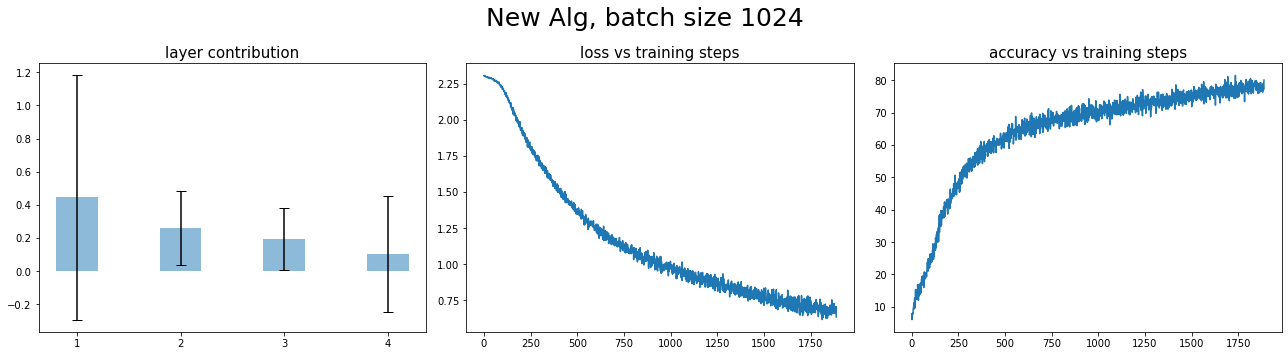

In [13]:
dict_bs1024 = {}
batch_size = 1024
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs1024.update({"NN_res": dict_NN})
dict_bs1024.update({"avgs": avgs})
dict_bs1024.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs1024["NN_res"][key][0,:]
train_acc_last_NN = dict_bs1024["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs1024["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

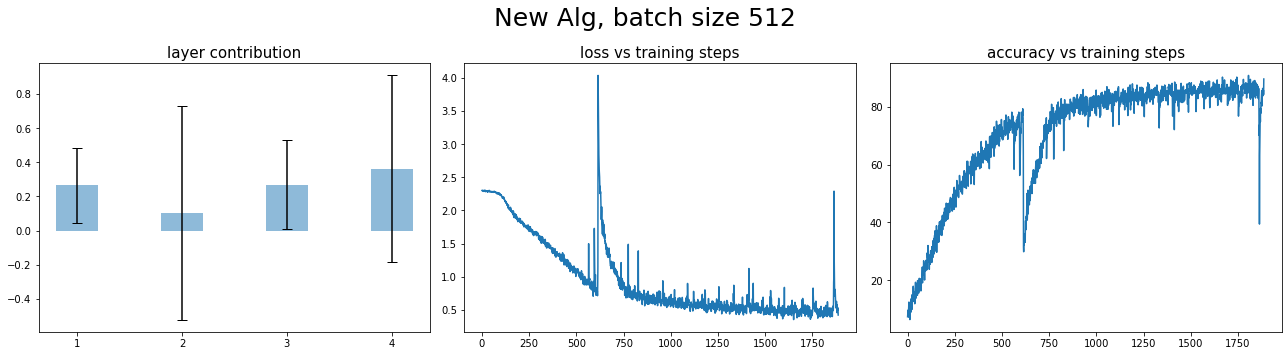

In [14]:
dict_bs512 = {}
batch_size = 512
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs512.update({"NN_res": dict_NN})
dict_bs512.update({"avgs": avgs})
dict_bs512.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs512["NN_res"][key][0,:]
train_acc_last_NN = dict_bs512["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs512["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

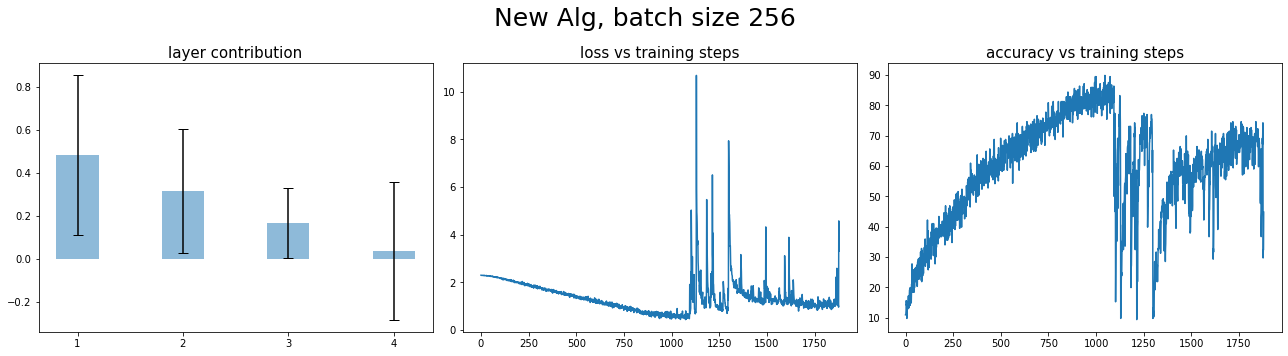

In [15]:
dict_bs256 = {}
batch_size = 256
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs256.update({"NN_res": dict_NN})
dict_bs256.update({"avgs": avgs})
dict_bs256.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs256["NN_res"][key][0,:]
train_acc_last_NN = dict_bs256["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs256["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

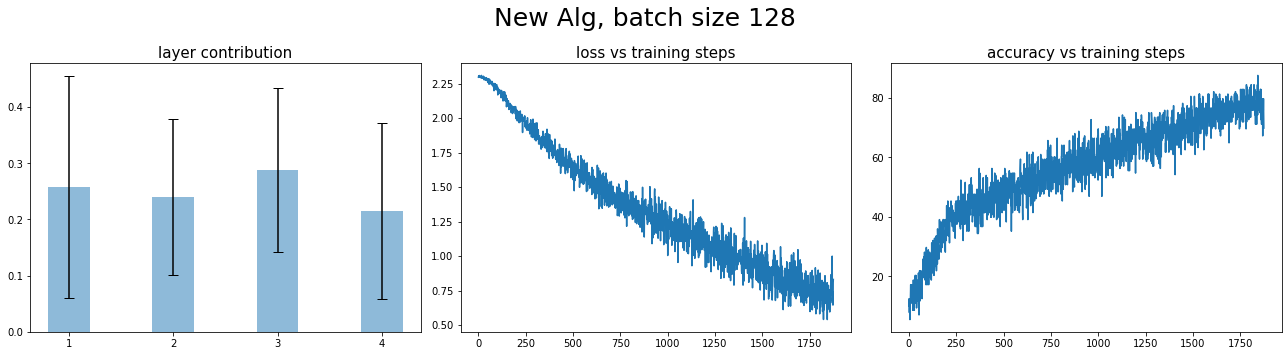

In [16]:
dict_bs128 = {}
batch_size = 128
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs128.update({"NN_res": dict_NN})
dict_bs128.update({"avgs": avgs})
dict_bs128.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs128["NN_res"][key][0,:]
train_acc_last_NN = dict_bs128["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs128["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

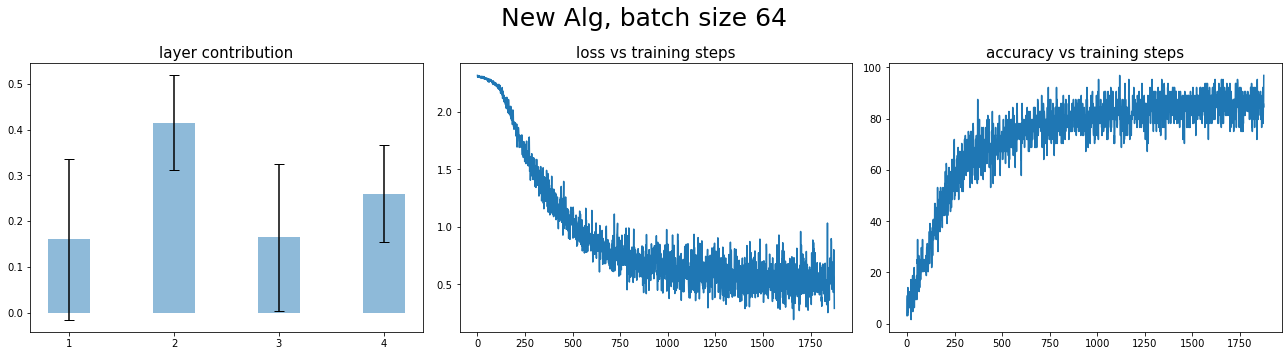

In [17]:
dict_bs64 = {}
batch_size = 64
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs64.update({"NN_res": dict_NN})
dict_bs64.update({"avgs": avgs})
dict_bs64.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs64["NN_res"][key][0,:]
train_acc_last_NN = dict_bs64["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs64["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

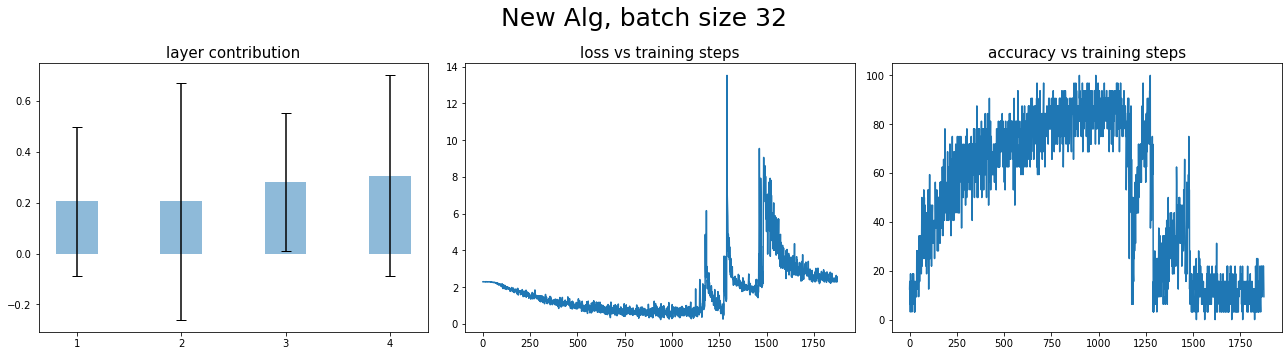

In [18]:
dict_bs32 = {}
batch_size = 32
n_epoch = round((1875*batch_size)/60000)
stds, avgs, dict_NN = layer_cont_avg(batch_size, alg, iterations, n_epoch)
dict_bs32.update({"NN_res": dict_NN})
dict_bs32.update({"avgs": avgs})
dict_bs32.update({"stds": stds})
key = "NN" + str(iterations - 1)
train_loss_last_NN = dict_bs32["NN_res"][key][0,:]
train_acc_last_NN = dict_bs32["NN_res"][key][1,:]
train_g_norm_last_NN = dict_bs32["NN_res"][key][2,:]
plot_res(train_loss_last_NN, train_acc_last_NN, stds, avgs, batch_size, alg)

In [19]:
dict_NA = {}
dict_NA.update({"bs1024": dict_bs1024})
dict_NA.update({"bs512": dict_bs512})
dict_NA.update({"bs256": dict_bs256})
dict_NA.update({"bs128": dict_bs128})
dict_NA.update({"bs64": dict_bs64})
dict_NA.update({"bs32": dict_bs32})

with open('dict_NA.pickle', 'wb') as file:
    pickle.dump(dict_NA, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('dict_NA.pickle', 'rb') as file:
    temp_dict = pickle.load(file)

temp_dict

{'bs1024': {'NN_res': {'NN0': array([[ 2.30683487,  2.30436244,  2.30453472, ...,  0.59290404,
            0.57159594,  0.62306136],
          [ 8.3984375 ,  9.5703125 ,  8.0078125 , ..., 82.2265625 ,
           82.32421875, 80.92105263],
          [ 0.1474532 ,  0.16227259,  0.15656506, ...,  0.45207982,
            0.41494369,  0.47159278]]),
   'NN1': array([[ 2.29958911,  2.3039673 ,  2.29964077, ...,  0.49762736,
            0.51496451,  0.50318579],
          [12.3046875 , 10.9375    , 14.16015625, ..., 85.83984375,
           83.7890625 , 84.21052632],
          [ 0.11028912,  0.12706574,  0.10579777, ...,  1.09141474,
            0.56567965,  0.3437632 ]]),
   'NN2': array([[ 2.30387868,  2.30545413,  2.30367093, ...,  0.61506443,
            0.62072598,  0.63134571],
          [10.15625   , 10.05859375, 10.64453125, ..., 81.0546875 ,
           79.8828125 , 79.76973684],
          [ 0.11416978,  0.1163748 ,  0.10959286, ...,  0.31682499,
            0.31110793,  0.2759205 ]]),

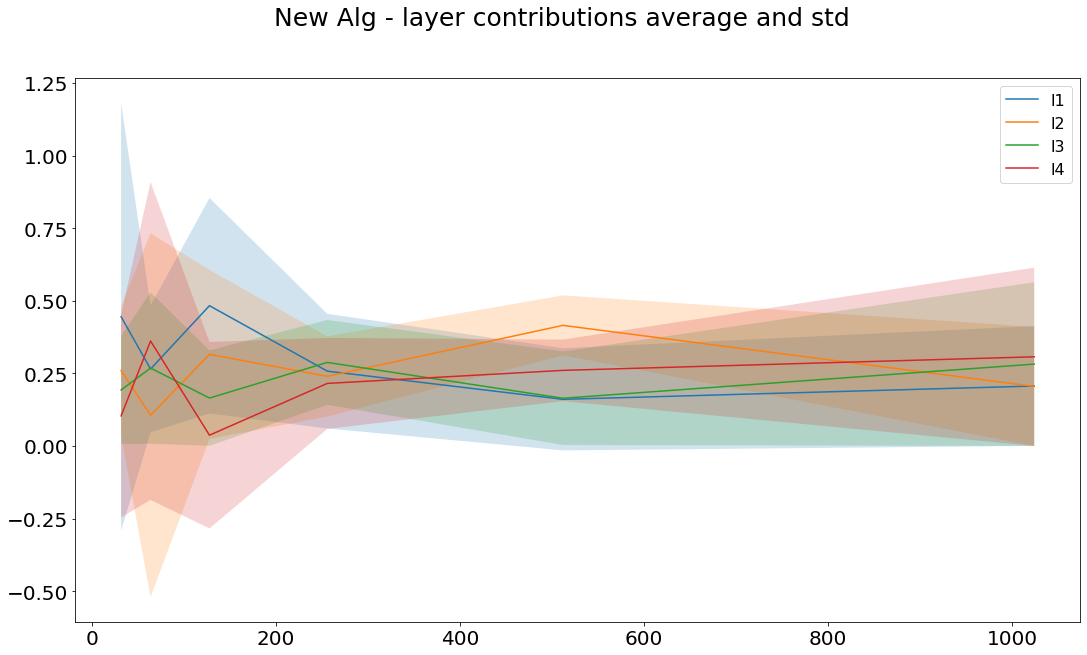

In [26]:
# results
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


batch_sizes = [32, 64 ,128 ,256 ,512 ,1024]
layer_cont = np.array([dict_NA["bs1024"]["avgs"], dict_NA["bs512"]["avgs"], dict_NA["bs256"]["avgs"], dict_NA["bs128"]["avgs"], dict_NA["bs64"]["avgs"], dict_NA["bs32"]["avgs"]]).T
layer_cont_std = np.array([dict_NA["bs1024"]["stds"], dict_NA["bs512"]["stds"], dict_NA["bs256"]["stds"], dict_NA["bs128"]["stds"], dict_NA["bs64"]["stds"], dict_NA["bs32"]["avgs"]]).T


fig = plt.figure(figsize=(18, 10))

fig.suptitle('New Alg - layer contributions average and std', fontsize=25)
for i in range(4):
    plt.plot(batch_sizes,layer_cont[i,:])
    plt.fill_between(batch_sizes, layer_cont[i,:]-layer_cont_std[i,:], layer_cont[i,:]+layer_cont_std[i,:], alpha=0.2)    
plt.legend(['l1', 'l2', 'l3', 'l4'], prop={'size': 16})


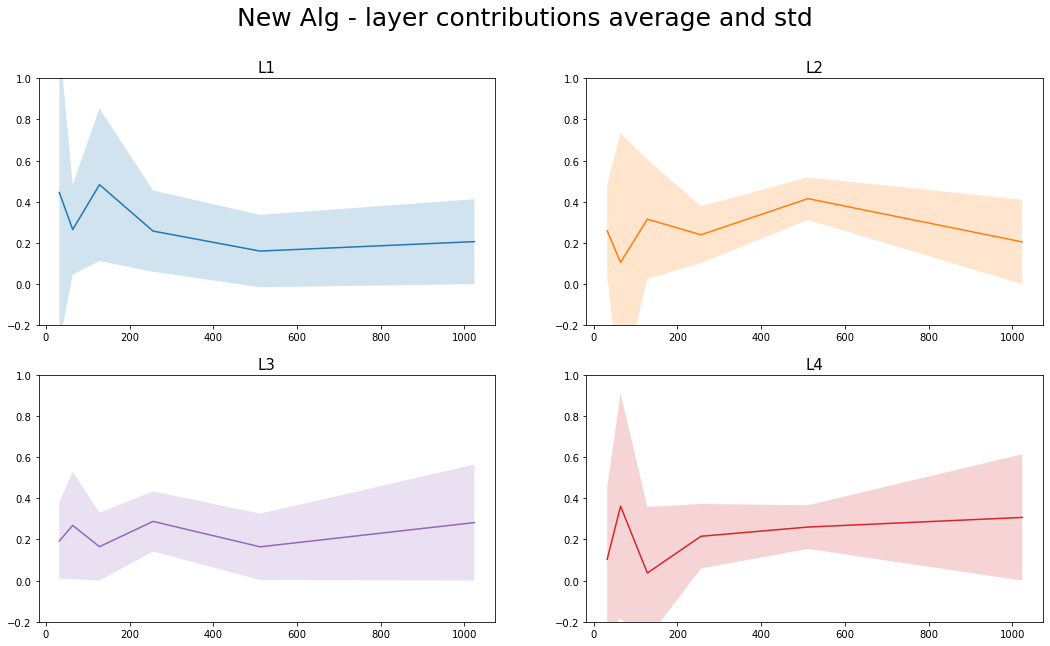

In [22]:
# results
fig = plt.figure(figsize=(18, 10))
fig.suptitle('New Alg - layer contributions average and std', fontsize=25)
colors = ['C0', 'C1', 'C4', 'C3']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    plt.plot(batch_sizes,layer_cont[i,:], colors[i])
    plt.fill_between(batch_sizes, layer_cont[i,:]-layer_cont_std[i,:], layer_cont[i,:]+layer_cont_std[i,:], facecolor = colors[i], alpha=0.2)
    title = 'L' + str(i+1)
    ax.set_title(title, fontsize=15)
    plt.ylim(-0.2, 1)


---